# TP Deep Clustering 


<img src="https://drive.google.com/uc?id=13dN55x2iT_Y29SRkq4748SxaYLfgt_Kp" width="1200">


L'objectif de ce TP consiste à créer un modèle constitué de plusieurs parties :

- Un auto-codeur, pré-entraîné pour apprendre la représentation condensée initiale des jeux de données non étiquetés.
- Une couche de clustering empilée sur l'encodeur pour affecter la sortie de l'encodeur à un cluster. Les poids de la couche de clustering sont initialisés avec les centres de cluster de K-Means basés sur l'évaluation actuelle.
- Entraîner le modèle de clustering pour affiner la couche de clustering et le codeur conjointement.


In [1]:
from time import time
import numpy as np
import keras.backend as K
from keras.layers import Dense, Input, Layer, InputSpec,  Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

2024-11-26 11:31:13.206446: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-26 11:31:13.266156: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-26 11:31:14.141335: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15221580478885860690
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2136539136
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9998431800694735566
physical_device_desc: "device: 0, name: NVIDIA RTX A500 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2024-11-26 11:31:16.511748: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-26 11:31:16.575840: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-26 11:31:16.576136: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Chargement des données

In [3]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist # à tester, + complexe que l'ensemble mnist 

import numpy as np

# Chargement et normalisation (entre 0 et 1) des données de la base de données MNIST/Fashion mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_trainIm = x_train.astype('float32') / 255.
x_testIm = x_test.astype('float32') / 255.

x_train = np.reshape(x_trainIm, (len(x_train), 784))
x_test = np.reshape(x_testIm, (len(x_test), 784))

# Nombre de classes à trouver
n_clusters=10

# Baseline par clustering classique par kmeans

In [4]:
# nombre de chiffres
n_digits = len(np.unique(y_test))

# Initialisation du Kmeans 
kmeans = MiniBatchKMeans(n_clusters = n_digits)

# Appliquer Kmeans sur base d'apprentissage
y_pred_kmeans=kmeans.fit_predict(x_train)

In [5]:
# Score de performance
accuracy_score(y_train, y_pred_kmeans)

0.058866666666666664

## Attribution des étiquettes de cluster

La classification K-means est une méthode d'apprentissage automatique non supervisée ; par conséquent, les étiquettes attribuées par notre algorithme KMeans font référence à la classification à laquelle chaque tableau a été attribué, et non à l'entier cible réel. Pour résoudre ce problème, définissons quelques fonctions qui prédiront quel nombre entier correspond à chaque cluster.

In [6]:
def retrieve_info(cluster_labels,y_train):
 #Associe l'étiquette la plus probable à chaque groupe dans le modèle KMeans.
 #Résultats : dictionnaire des clusters associés à chaque étiquette.

# Initialisation
  reference_labels = np.zeros((len(np.unique(cluster_labels)),1))
# Loop pour chaque label 
  for i in range(len(np.unique(cluster_labels))):
    index = np.where(cluster_labels == i,1,0)
    num = np.bincount(y_train[index==1]).argmax()
    reference_labels[i] = num
  return reference_labels

In [7]:
def correspondance(y_pred_kmeans,y_train):
  # Correspondance entre la partition et les classes de la vérité terrain
  reference_labels = retrieve_info(y_pred_kmeans,y_train)
  number_labels = np.zeros(len(y_pred_kmeans))
  for i in range(len(y_pred_kmeans)):
    number_labels[i] = reference_labels[y_pred_kmeans[i]]
  return number_labels


In [8]:
# Score de performance sur l'apprentissage après correspondance entre les classes
# A COMPLETER
accuracy_score(y_train, correspondance(y_pred_kmeans,y_train))

/tmp/ipykernel_42083/111057547.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred_kmeans[i]]


0.5743666666666667

In [9]:
# Affichage des données 
count=2000
ListeData = np.random.choice(len(x_test), count)
inputs = x_train[ListeData]
classes = y_train[ListeData]

# Appliquer une réduction de données en 2D via la TSNE
# A COMPLETER
coordsTSNE = TSNE(n_components=2).fit_transform(inputs)


# Autoencodeur classique à définir 

In [10]:
# Architecture de l'autoencodeur
# à coder
# Dimensions
input_dim = inputs.shape[1]  # Exemple : données MNIST (28x28 images aplaties)
encoding_dim = 20  # Dimension réduite finale

# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(256, activation='relu')(input_layer)  # Première couche
encoded = Dense(128, activation='relu')(encoded)  # Deuxième couche
encoded = Dense(encoding_dim, activation='relu')(encoded)  # Couche finale encodée

# Decoder
decoded = Dense(128, activation='relu')(encoded)  # Première couche
decoded = Dense(256, activation='relu')(decoded)  # Deuxième couche
decoded = Dense(input_dim, activation='sigmoid')(decoded)  # Couche finale

# Autoencodeur
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Compile l'autoencodeur
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
# FIN à coder

2024-11-26 11:31:29.140117: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-26 11:31:29.140641: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-26 11:31:29.141012: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [11]:
# Autoencodeur summary
# à coder
# Résumé du modèle
autoencoder.summary()
# FIN à coder

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │         2,580 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 473,636 (1.81 MB)

 Trainable params: 473,636 (1.81 MB)

 Non-trainable params: 0 (0.00 B)

# Entraînement de l'autoencodeur 

In [12]:
# Entraînement de l'autoencodeur 
autoencoder.fit(x_train, x_train,
                epochs=25,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/25


I0000 00:00:1732617091.922510   43355 service.cc:145] XLA service 0x7ac41c00b710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732617091.922558   43355 service.cc:153]   StreamExecutor device (0): NVIDIA RTX A500 Laptop GPU, Compute Capability 8.6
2024-11-26 11:31:31.966526: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-26 11:31:32.193213: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1732617093.657289   43442 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_564', 116 bytes spill stores, 116 bytes spill loads

I0000 00:00:1732617093.777248   43440 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_556', 148 bytes spill stores, 148 bytes spill loads

I0000

 56/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4631

I0000 00:00:1732617101.574360   43355 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


451/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2678

I0000 00:00:1732617104.314450   43674 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_564', 116 bytes spill stores, 116 bytes spill loads

I0000 00:00:1732617105.966245   43669 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_273', 32 bytes spill stores, 48 bytes spill loads

I0000 00:00:1732617106.040726   43682 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_564', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1732617107.271979   43665 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_562', 128 bytes spill stores, 128 bytes spill loads

I0000 00:00:1732617107.564655   43669 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_556', 128 bytes spill stores, 128 bytes spill loads

I0000 00:00:1732617107.876695  

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2649

I0000 00:00:1732617114.332674   43945 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_56', 16 bytes spill stores, 16 bytes spill loads



469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - loss: 0.2647 - val_loss: 0.1358
Epoch 2/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1310 - val_loss: 0.1161
Epoch 3/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1151 - val_loss: 0.1088
Epoch 4/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1090 - val_loss: 0.1048
Epoch 5/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1053 - val_loss: 0.1023
Epoch 6/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1026 - val_loss: 0.1001
Epoch 7/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1010 - val_loss: 0.0990
Epoch 8/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0995 - val_loss: 0.0978
Epoch 9/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0983 - val_loss: 0.0968
Epoch 10/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0970 - val_loss: 0.0962
Epoch 11/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0963 - val_loss: 0.0954
Epoch 12/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 

In [19]:
# Encoder et décoder quelques chiffres de l'ensemble test
sorties_test = autoencoder.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step


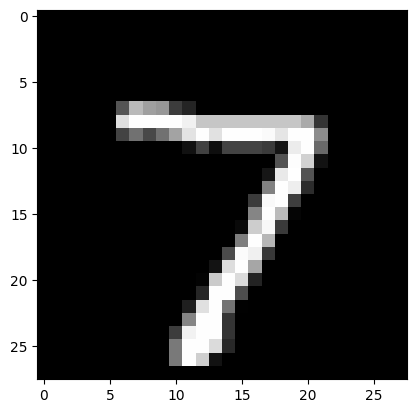

In [20]:
plt.imshow(np.reshape(x_test[0], (28, 28)), cmap='gray')

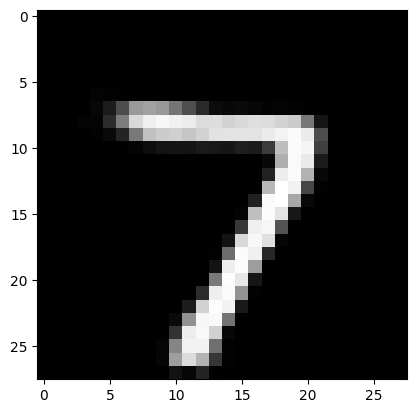

In [21]:
plt.imshow(np.reshape(sorties_test[0], (28, 28)), cmap='gray')

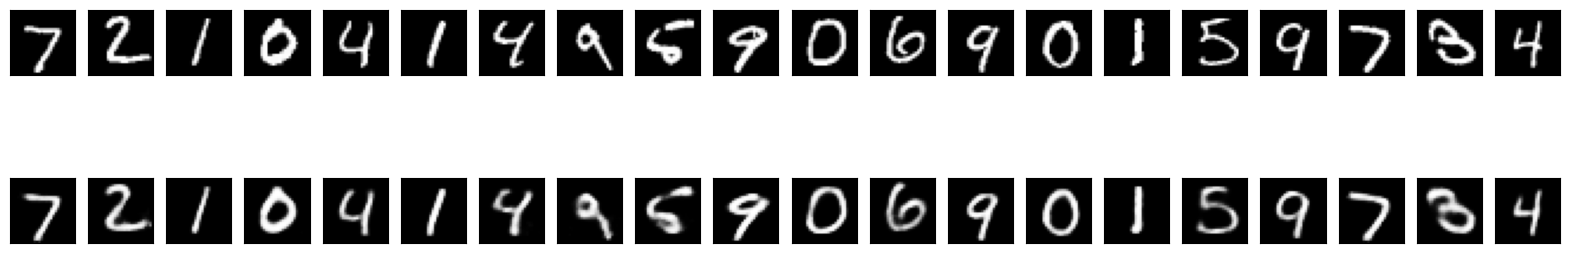

In [22]:
n = 20  # Combien de chiffres nous allons afficher

# Afficher l'image reconstruite à partir de l'espace latent après entraînement
# À COMPLÉTER
plt.figure(figsize=(20, 4))
for i in range(n):
    # Affichage de l'image originale
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Affichage de l'image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(sorties_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


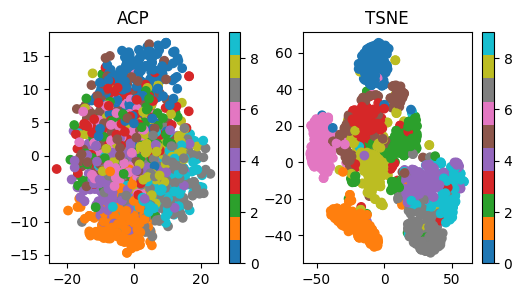

In [23]:
# Affichage de l'espace latent par réduction de dimension 
count=2000
inputs = x_train[ListeData]
classes = y_train[ListeData]
# FIN À COMPLÉTER

# Récupération des données dans l'espace latent
# À COMPLÉTER
latent_representation = Model(input_layer, encoded)
encoded_imgs = latent_representation.predict(inputs)
# FIN À COMPLÉTER


# Réduction de dimension 2D par ACP
# À COMPLÉTER
pca = PCA(n_components=2)
inputs_red_pca = pca.fit_transform(encoded_imgs)
# FIN À COMPLÉTER


# Réduction de dimension 2D par la TSNE
# À COMPLÉTER
coordsTSNE_AC = TSNE(n_components=2).fit_transform(encoded_imgs)
# FIN À COMPLÉTER


# Affichage de l'espace latent par ACP et TSNE
# À COMPLÉTER
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.scatter(inputs_red_pca[:, 0], inputs_red_pca[:, 1], c=classes, cmap='tab10')
plt.title('ACP')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(coordsTSNE_AC[:, 0], coordsTSNE_AC[:, 1], c=classes, cmap='tab10')
plt.title('TSNE')
plt.colorbar()
# FIN À COMPLÉTER

In [24]:
# Classification par kmeans de l'espace latent sur l'ensemble d'apprentissage

# Initialisation du Kmeans 
kmeans = MiniBatchKMeans(n_clusters = n_digits)

# Affichage
inputsTrain = x_train
classesTrain = y_train


# Kmeans sur base d'apprentissage
# À COMPLÉTER
y_pred_kmeans=kmeans.fit_predict(encoded_imgs)
# FIN À COMPLÉTER

# Score de performance sur l'apprentissage
# À COMPLÉTER
acc_kmeans_latent = accuracy_score(classes, correspondance(y_pred_kmeans,classes))
# FIN À COMPLÉTER

print("Performance de l'autoencodeur : accuracy sur kmeans sur l'espace latent")
print(acc_kmeans_latent)

Performance de l'autoencodeur : accuracy sur kmeans sur l'espace latent
0.525


/tmp/ipykernel_42083/111057547.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred_kmeans[i]]


## Couche de clustering 
maintient les centres de cluster $\mu_j$ comme poids entraînables et projette chaque point intégré $z_i$ en soft label $q_i$ par la distribution $t$ de Student:
$$q_{ij}=\frac{(1+\|z_i-\mu_j\|^2)^{-1}}{\sum_j(1+\|z_i-\mu_j\|^2)^{-1}}$$
où $q_{ij}$ est la $j$ième entrée de $q_i$, représentant la probabilité d'appartenance de $z_i$ au cluster $j$.

In [25]:
import tensorflow as tf # AJOUT

class ClusteringLayer(Layer):
    """
    La couche de classification convertit l'échantillon d'entrée (caractéristique) en une étiquette souple, c'est-à-dire un vecteur qui représente la probabilité d'appartenance de l'échantillon à chaque groupe.
    probabilité d'appartenance de l'échantillon à chaque cluster. La probabilité est calculée avec la distribution t de student.
    # Exemple
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters : nombre de clusters.
        weights : liste de tableaux Numpy de forme `(n_clusters, n_features)` qui représente les centres de clusters initiaux.
        alpha : paramètre de la distribution t de Student. La valeur par défaut est 1.0.
    # Forme de l'entrée
        Tenseur 2D avec la forme : `(n_samples, n_features)`.
    # Forme en sortie
        Tenseur 2D avec forme : `(n_samples, n_clusters)`.
    """


    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
      """ Distribution t de student, la même que celle utilisée dans l'algorithme t-SNE.
                 q_ij = 1/(1+dist(x_i, u_j)^2), puis normalisation.
        Arguments :
            inputs : la variable contenant les données, shape=(n_samples, n_features)
        Retourne :
            q : la distribution t de student, ou des étiquettes souples pour chaque échantillon. shape=(n_samples, n_clusters)
        """
      q = 1.0 / (1.0 + (tf.reduce_sum(tf.square(tf.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))       # ON REMPLACE "K.sum(...)" PAR "tf.reduce_sum(...)" ET "K.square(...)" PAR "tf.square(...)" ET "K.expand_dims(...)" PAR "tf.expand_dims(...)"
      q **= (self.alpha + 1.0) / 2.0
      q = tf.transpose(tf.transpose(q) / tf.reduce_sum(q, axis=1))                                                            # ON REMPLACE "K.sum(...)" PAR "tf.reduce_sum(...)" ET "K.transpose(...)" PAR "tf.transpose(...)"     
      return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


Définition de la distribution $P$ cible définie comme
$$p_{ij}=\frac{q_{ij}^2/\sum_i q_{ij}}{\sum_j (q_{ij}^2/\sum_i q_{ij})}.$$
où $p_{ij}$ est la $j$-ième entrée de $p_i$ représentant la probabilité d'appartenance de la donnée $i$ la classe $j$

In [26]:
# Calcul de la distribution cible
def target_distribution(q):
  # à compléter
  weight = q ** 2 / q.sum(0)
  return (weight.T / weight.sum(1)).T
  # FIN à compléter

In [27]:
# Configuration de la couche de clustering
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(latent_representation.output)     # REMPLACEMENT DE "encoder" par "latent_representation"
model = Model(inputs=latent_representation.input, outputs=clustering_layer)                         # REMPLACEMENT DE "encoder" par "latent_representation"

model.compile(optimizer="Adam", loss='kld')

# Entrainement du modèle avec la couche de clustering

In [31]:
# paramètres à fixer
loss = 0
index = 0
maxiter = 1000 # on change de 4000 à 1000
update_interval = 140
batch_size=128
index_array = np.arange(x_train.shape[0])
tol = 0.005 # seuil pour critère d'arrêt

In [32]:
#Initialisation Kmeans
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(latent_representation.predict(x_train))           # REMPLACEMENT DE "encoder" par "latent_representation"

# récupération des centres de clusters   
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x_train, verbose=0)
        p = target_distribution(q)  # mise à jour de la distribution cible p 

        # evaluation de la performance du clustering 
        y_pred = q.argmax(1)
        if y_train is not None: 
            y_pred=correspondance(y_pred,y_train)
            acc = np.round(accuracy_score(y_train, y_pred), 5)
            loss = np.round(loss, 5)
            print('(Iter , acc)  ',(ite, acc), ' ; loss=', loss)

        # check stop criterion - model convergence
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x_train.shape[0])]
    loss = model.train_on_batch(x=x_train[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x_train.shape[0] else 0

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step


/tmp/ipykernel_42083/111057547.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred_kmeans[i]]


(Iter , acc)   (0, 0.59668)  ; loss= 0


/tmp/ipykernel_42083/111057547.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred_kmeans[i]]


(Iter , acc)   (140, 0.60213)  ; loss= 0.09505


/tmp/ipykernel_42083/111057547.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred_kmeans[i]]


(Iter , acc)   (280, 0.60902)  ; loss= 0.13995


/tmp/ipykernel_42083/111057547.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred_kmeans[i]]


(Iter , acc)   (420, 0.62092)  ; loss= 0.15934


/tmp/ipykernel_42083/111057547.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred_kmeans[i]]


(Iter , acc)   (560, 0.62603)  ; loss= 0.17021


/tmp/ipykernel_42083/111057547.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred_kmeans[i]]


(Iter , acc)   (700, 0.63097)  ; loss= 0.17691


/tmp/ipykernel_42083/111057547.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred_kmeans[i]]


(Iter , acc)   (840, 0.63528)  ; loss= 0.1808


/tmp/ipykernel_42083/111057547.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred_kmeans[i]]


(Iter , acc)   (980, 0.63593)  ; loss= 0.18153


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


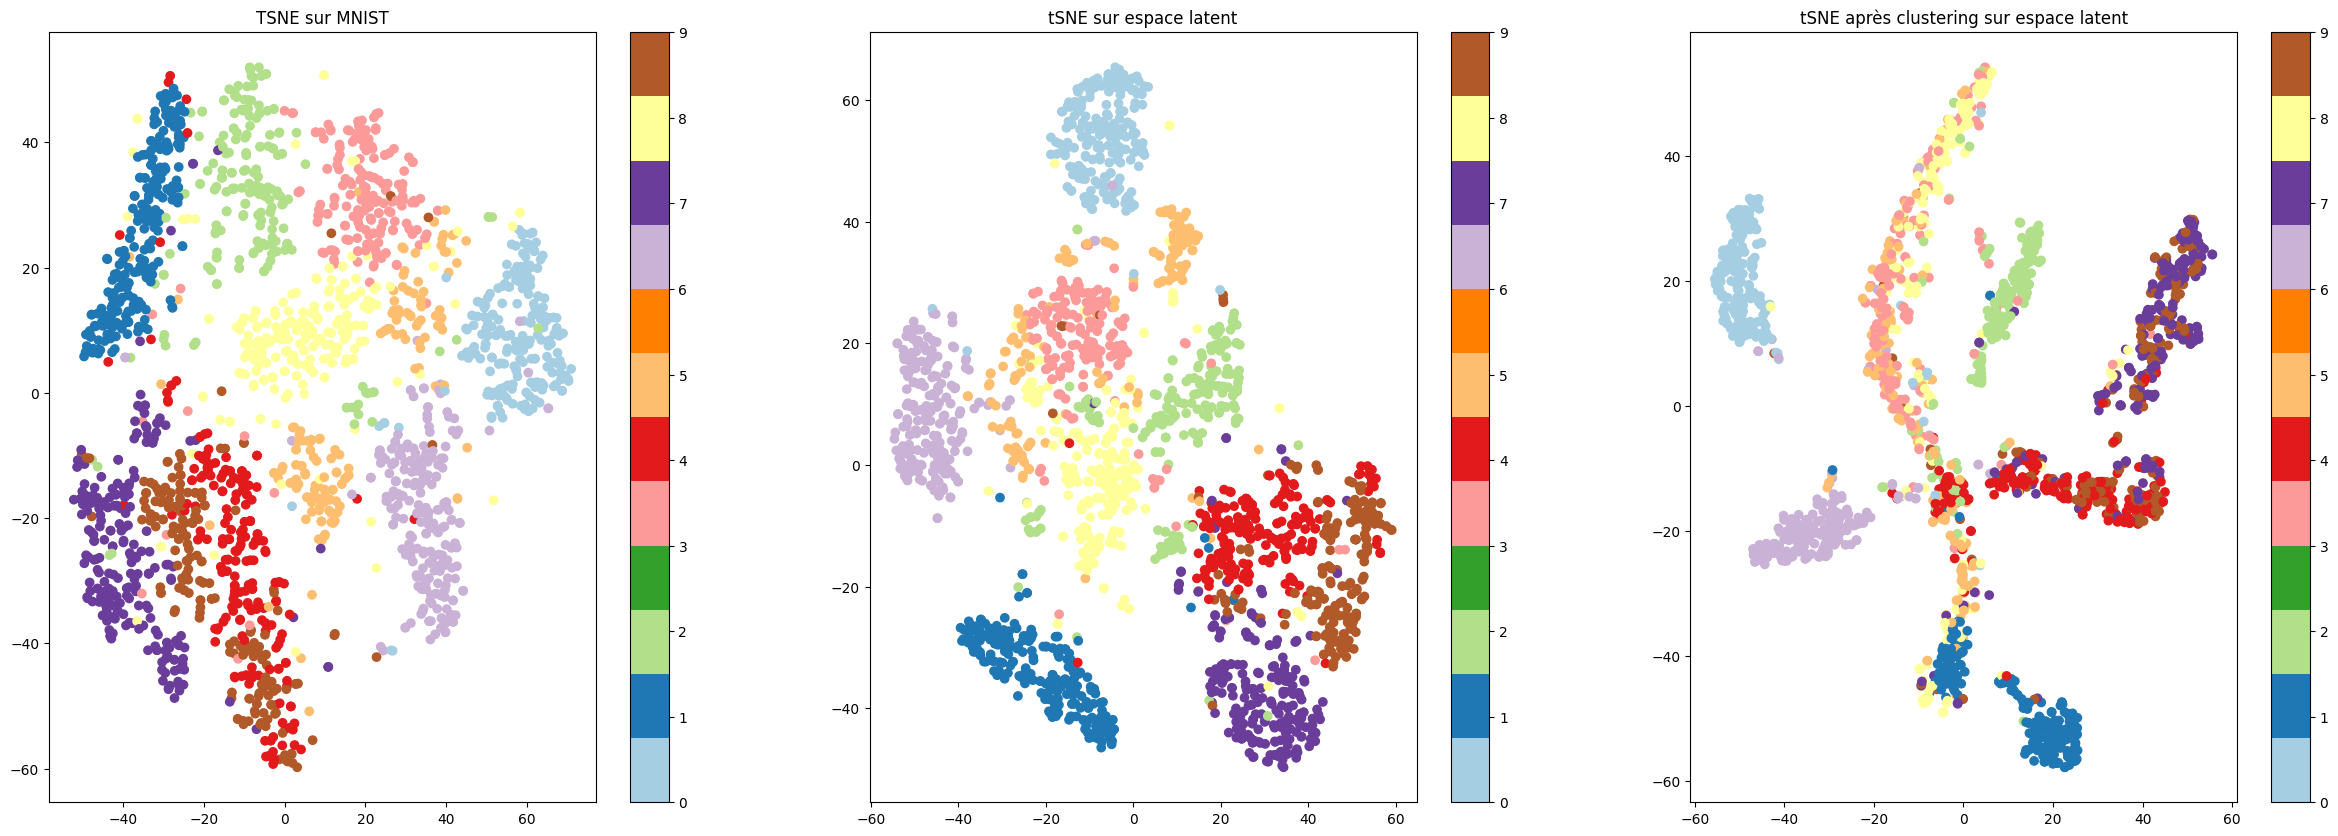

In [34]:
# Affichage de l'impact de cette couche clustering 

inputs = x_train[ListeData]
classes = y_train[ListeData]

# TSNE sur espace latent avec kmeans
coordsAC_V2 = latent_representation.predict(inputs)                                                       # REMPLACEMENT DE "encoder" par "latent_representation"
coordsTSNE_V2 = TSNE(n_components=2).fit_transform(coordsAC_V2.reshape(count, -1))


fig2= plt.figure(figsize=(30, 10))
ax2=plt.subplot(1,3,1)
ax2.set_title("TSNE sur MNIST")
plt.scatter(coordsTSNE[:, 0], coordsTSNE[:, 1], c=classes,cmap='Paired')
plt.colorbar()


ax2 = plt.subplot(1,3,2)
ax2.set_title("tSNE sur espace latent")
plt.scatter(coordsTSNE_AC[:, 0], coordsTSNE_AC[:, 1], c=classes,cmap='Paired')
plt.colorbar()



ax2 = plt.subplot(1,3,3)
ax2.set_title("tSNE après clustering sur espace latent")
plt.scatter(coordsTSNE_V2[:, 0], coordsTSNE_V2[:, 1], c=classes,cmap='Paired')
plt.colorbar()

# Passer à la version convolutive de l'autoencodeur